# CMPUT 466/566, Winter 2020 Introduction to Machine learning 
## Coding Assignment 2 
### Problem 1 Report
By Nathan Klapstein #1449872

In [1]:

import struct

import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.sparse


Load in the MNIST data for later compute.

In [2]:

def readMNISTdata():
    with open('data/t10k-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows * ncols))

    with open('data/t10k-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size, 1))

    with open('data/train-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows * ncols))

    with open('data/train-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size, 1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate(
        (np.ones([train_data.shape[0], 1]), train_data), axis=1)
    test_data = np.concatenate((np.ones([test_data.shape[0], 1]), test_data),
                               axis=1)
    np.random.seed(314)
    np.random.shuffle(train_labels)
    np.random.seed(314)
    np.random.shuffle(train_data)

    X_train = train_data[:50000] / 256
    t_train = train_labels[:50000]

    X_val = train_data[50000:] / 256
    t_val = train_labels[50000:]

    return X_train, t_train, X_val, t_val, test_data, test_labels


X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()

print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape)


(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)


Various global configurations.

In [10]:
N_class = 10

# original defined hyper parameters
# alpha = 0.1  # learning rate
# batch_size = 100  # batch size
# MaxIter = 50  # Maximum iteration
# decay = 0.  # weight decay


alpha = 0.4  # learning rate
num_batches = 2
batch_size = 50000 // num_batches 
MaxIter = 50  # Maximum iteration
decay = 0.0  # weight decay

lam = 0.4  # regularization loss multiplier
verbose = True

In [11]:

def oneHotIt(Y):
    """Convert unidimensional array of labels into a one-hot variant
    where the array is size m (examples) x n (classes)."""
    m = Y.shape[0]
    Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX


def softmax(z):
    z -= np.max(z) + np.min(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm


def getLoss(w, x, y):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T, (y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss, grad


def getProbsAndPreds(someX, w):
    probs = softmax(np.dot(someX, w))
    preds = np.argmax(probs,axis=1)
    return probs,preds


# inspired by https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16
# https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
def getAccuracy(someX, someY, w):
    prob, prede = getProbsAndPreds(someX,w)
    someY = someY.flatten()
    num_correct = np.sum(prede == someY)
    num_incorrect = np.sum(prede != someY)
    accuracy = num_correct/(num_correct+num_incorrect)
    return accuracy, num_correct, num_incorrect


def predict(x, w, t=None):
    # X_new: Nsample x (d+1)
    # W: (d+1) x K
    
    # TODO Your code here
    y = np.matmul(x, w)
    
    t_hat = np.argmax(y, axis=1)
    
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(t) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) # compute the loss
    
    # compute the mean-per class accuracy
    acc = getAccuracy(x, t, w)
    
    return y, t_hat, loss, acc


def train(X_train, t_train, X_val, t_val):
    N_train = X_train.shape[0]
    N_val = X_val.shape[0]

    # TODO Your code here
    
    # initialization
    w = np.zeros([X_train.shape[1], N_class])
    # w: (d+1)x1

    losses_train = []
    acc_val = []
    w_best = None
    acc_best = 0
    epoch_best = 0
    
    print(f"running {int(np.ceil(N_train / batch_size))} batches of size {batch_size} over data size {X_train.shape[0]} for {MaxIter} epochs")
    for epoch in range(MaxIter):
        loss_this_epoch = 0
        for b in range(int(np.ceil(N_train / batch_size))):
            X_batch = X_train[b * batch_size: (b + 1) * batch_size]
            t_batch = t_train[b * batch_size: (b + 1) * batch_size]
            loss_batch, grad = getLoss(w, X_batch, t_batch)
            loss_this_epoch += loss_batch
            
            # gradient decent with simple weight decay
            w = w - (alpha * grad) - (alpha * decay * w)
   
        # TODO: Your code here
        # monitor model behavior after each epoch
        
        # 1. Compute the training loss by averaging loss_this_epoch    
        loss_this_epoch = loss_this_epoch / (int(np.ceil(N_train/batch_size)))
        val_acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, w)
        if verbose:
            print(f"epoch {epoch:>3}/{MaxIter:<2} loss:{loss_this_epoch:.18f} val_acc:{val_acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
        losses_train.append(loss_this_epoch)

        # 2. Perform validation on the validation test by the risk
        # TODO: FIXED: Validation set should not be run in batches
        acc_val.append(val_acc)
        
        # 3. Keep track of the best validation epoch, risk, and the weights
        if acc_val[epoch] >= acc_best:
            epoch_best = epoch
            acc_best = acc_val[epoch]
            w_best = w

    # Return some variables as needed
    return epoch_best, losses_train, acc_val, acc_best, w_best


def plot_training_losses(losses_train):
    fig = plt.figure()
    plt.plot(losses_train, label="Training Losses")
    plt.title("Training Losses")
    plt.legend()
    plt.xlabel('Number of epoch')
    plt.ylabel('Training Loss')
    plt.show()
    
    
def plot_training_accuracy(acc_val):
    fig = plt.figure()
    plt.plot(acc_val, label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.xlabel('Number of epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()
    

In [12]:

epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)

print(f"best epoch: {epoch_best} acc:{acc_best:.6f}")


running 2 batches of size 25000 over data size 50000 for 50 epochs
epoch   0/50 loss:2.127264997218138554 val_acc:0.772800 correct|incorrect:7728|2272
epoch   1/50 loss:1.738709922547925224 val_acc:0.792100 correct|incorrect:7921|2079
epoch   2/50 loss:1.646921822060057217 val_acc:0.802100 correct|incorrect:8021|1979
epoch   3/50 loss:1.623803158909894684 val_acc:0.807700 correct|incorrect:8077|1923
epoch   4/50 loss:1.617326411463954061 val_acc:0.810700 correct|incorrect:8107|1893
epoch   5/50 loss:1.615295377323858306 val_acc:0.813700 correct|incorrect:8137|1863
epoch   6/50 loss:1.614583506426771287 val_acc:0.816400 correct|incorrect:8164|1836
epoch   7/50 loss:1.614307247967438963 val_acc:0.817200 correct|incorrect:8172|1828
epoch   8/50 loss:1.614190368866091463 val_acc:0.817900 correct|incorrect:8179|1821
epoch   9/50 loss:1.614137328170585084 val_acc:0.818200 correct|incorrect:8182|1818
epoch  10/50 loss:1.614111839776351198 val_acc:0.818900 correct|incorrect:8189|1811
epoch  11

The learning curve of the training loss, where x-axis is the number of epochs,
and y-axis is the training loss.

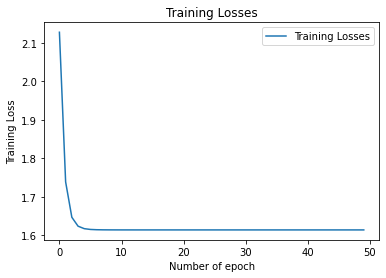

In [13]:
plot_training_losses(losses_train)

The accuracy curve, where x-axis is the number of epochs, and y-axis is the 
accuracy in decimal form (0.0-1.0).

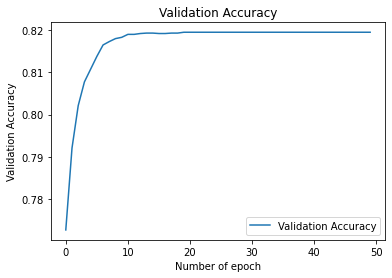

In [14]:
plot_training_accuracy(acc_val)

Getting accuracy of the learned model on the test set.

In [15]:

acc_test, num_correct, num_incorrect = getAccuracy(X_test, t_test, W_best)
print(f"tst_acc:{acc_test:.6f} correct|incorrect:{num_correct}|{num_incorrect}")


tst_acc:0.829000 correct|incorrect:8290|1710


c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


### Problem 2 Report

Ask one meaningful scientific question yourself, design your experimental 
protocol, present results, and draw a conclusion.  

#### Scientific Question

With proper tailoring of the hyperparameters:

* ``alpha`` - learning rate
* ``batch_size`` -  batch size
* ``MaxIter`` - number of epochs
* ``decay`` - weight decay
* ``lam`` - regularization loss multiplier

Can we obtain a accuracy better than 83% 83% on the test set?

If so what is the most efficient method of maximizing accuracy performance 
given these configurations?

Additionally, I see in my training accuracy it looks similar to a logarithmic
curve approaching to 0.82, is there a possible way to prevent this limiting 
cap?

#### Experimental Protocol

Re-run the expirement tuning the hyperparamters 

#### Experimental Results

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
running 16 batches of size 3125 over data size 50000 for 30 epochs
trn_acc:0.898560 correct|incorrect:44928|5072
val_acc:0.896200 correct|incorrect:8962|1038
tst_acc:0.891500 correct|incorrect:8915|1085


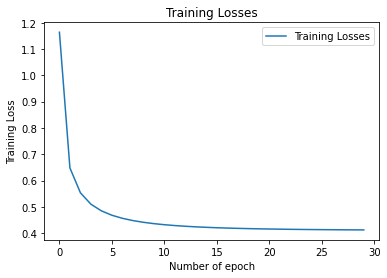

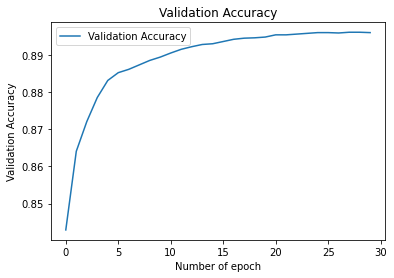

c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [9]:

X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()

print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape)

# # 88 test accuacy
# alpha = 0.1  # learning rate
# num_batches = 10
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 50  # Maximum iteration
# decay = 0.01  # weight decay
# lam = 0.04  # regularization loss multiplier

# 89.25 test accuacy
# alpha = 0.3  # learning rate
# num_batches = 10
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 100  # Maximum iteration
# decay = 0.02  # weight decay
# lam = 0.00000003  # regularization loss multiplier
# 

# 90.8 val accuracy 79 test accuacy
# alpha = 0.4  # learning rate
# num_batches = 20
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 100  # Maximum iteration
# decay = 0.0025  # weight decay
# lam = 0.00000003  # regularization loss multiplier


# # feels like over fitting

# alpha = 0.3  # learning rate
# num_batches = 10
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 100  # Maximum iteration
# decay = 0.002  # weight decay
# lam = 0.0000003  # regularization loss multiplier


# 
# def softmax(z):
#     z -= np.max(z) + np.min(z)
#     sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
#     return sm



# trn_acc:0.894380 correct|incorrect:44719|5281
# val_acc:0.891500 correct|incorrect:8915|1085
# tst_acc:0.894400 correct|incorrect:8944|1056
# alpha = 0.36  # learning rate
# num_batches = 10
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 50  # Maximum iteration
# decay = 0.014  # weight decay
# lam = 0.00000003  # regularization loss multiplier
# verbose = False

# 
# trn_acc:0.899320 correct|incorrect:44966|5034
# val_acc:0.896500 correct|incorrect:8965|1035
# tst_acc:0.892700 correct|incorrect:8927|1073
# alpha = 0.37  # learning rate
# num_batches = 16
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 200  # Maximum iteration
# decay = 0.01  # weight decay
# lam = 0.00000003  # regularization loss multiplier
# verbose = False


# trn_acc:0.899320 correct|incorrect:44966|5034
# val_acc:0.896500 correct|incorrect:8965|1035
# tst_acc:0.892700 correct|incorrect:8927|1073
# good all round accuracy performance, good training performance with low number of iterations
# alpha = 0.37  # learning rate
# num_batches = 16
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 75  # Maximum iteration
# decay = 0.01  # weight decay
# lam = 0.00000003  # regularization loss multiplier
# verbose = False


# trn_acc:0.898560 correct|incorrect:44928|5072
# val_acc:0.896200 correct|incorrect:8962|1038
# tst_acc:0.891500 correct|incorrect:8915|1085
# 
# alpha = 0.4  # learning rate
# num_batches = 16
# batch_size = 50000 // num_batches  # batch size
# MaxIter = 30  # Maximum iteration
# decay = 0.01  # weight decay
# lam = 0.000003  # regularization loss multiplier
# verbose = False


alpha = 0.4  # learning rate
num_batches = 16
batch_size = 50000 // num_batches  # batch size
MaxIter = 30  # Maximum iteration
decay = 0.01  # weight decay
lam = 0.000003  # regularization loss multiplier
verbose = False


epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)
plot_training_losses(losses_train)
plot_training_accuracy(acc_val)

acc, num_correct, num_incorrect = getAccuracy(X_train, t_train, W_best)
print(f"trn_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, W_best)
print(f"val_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
acc, num_correct, num_incorrect = getAccuracy(X_test, t_test, W_best)
print(f"tst_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")

#### Conclusion


Tuning the hyperparamters as shown within the experimental results noted a 
increase in test accuracy from 83% to 89% which is a relatively good improvement.